# After training analysis
Create table and plots; reuse code from `mlp-classifier-experiments
`

In [63]:
import pickle

import string
import editdistance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [116]:
sns.set_theme()
sns.set_context('paper', font_scale=1.4)
plt.style.use('ggplot')
pd.set_option('precision', 4)

In [65]:
punctuations = set(string.punctuation)
stopwords = set(nltk.corpus.stopwords.words('english'))
ps = nltk.PorterStemmer()

In [66]:
def load_file(path, skip_id=False, has_label=True):
    """
    has_label: also return label column if True
    return [['hello world', 'hi'], ['hi World', 'hello']]
    """
    first_lines = []
    second_lines = []
    if has_label:
        labels = []
    if skip_id:
        start_col_idx = 1
    else:
        start_col_idx = 0
    with open(path, 'rt') as f:
        for line in f:
            chunks = line.strip().split('\t')
            first = chunks[start_col_idx]
            second = chunks[start_col_idx + 1]
            first_lines.append(first)
            second_lines.append(second)
            
            if has_label:
                label = int(chunks[start_col_idx + 2])
                labels.append(label)
    if has_label:
        ret = pd.DataFrame({
            'line1': first_lines, 
            'line2': second_lines, 
            'is_paraphrase': labels
        })
    else:
        ret = pd.DataFrame({
            'line1': first_lines, 
            'line2': second_lines
        })
    return ret

In [67]:
def clean_text(text, remove_punkt=False, remove_stopwords=False, stem=False):
    tokens = word_tokenize(text.lower())
    if remove_punkt:
        tokens = [tok for tok in tokens if not tok in punctuations]
    if remove_stopwords:
        tokens = [tok for tok in tokens if not tok in stopwords]
    if stem:
        tokens = [ps.stem(tok) for tok in tokens]
    return tokens

In [68]:
def construct_features(first_lines, second_lines):
    # number of unique overlapping unigrams, edit distance
    features = np.empty((len(first_lines), 2))
    for idx, tup in enumerate(zip(first_lines, second_lines)):
        first, second = tup
        num_unigrams = len(set(first).intersection(second))
        edit_dist = editdistance.eval(first, second)
        features[idx, 0] = num_unigrams
        features[idx, 1] = edit_dist
    return features

In [4]:
dev = load_file('data/dev+devtest/dev.tsv')
devtest = load_file('data/dev+devtest/devtest.tsv')
test = load_file('data/test_no_labels.tsv', skip_id=True, has_label=False)
dev_hard = load_file('data/heldout-hard/dev.hard.tsv')
devtest_hard = load_file('data/heldout-hard/devtest.hard.tsv')
test_hard = load_file('data/heldout-hard/test.hard.tsv', has_label=False)

In [109]:
len(dev), len(devtest), len(test), len(dev_hard), len(devtest_hard), len(test_hard)

(818, 805, 3000, 1000, 1000, 3000)

In [5]:
with open('output/mlp-experiments.pkl', 'rb') as f:
    experiments = pickle.load(f)

In [6]:
results = pd.read_csv('output/mlp-results.csv')

# Accuracy tables and plots

In [34]:
results.sort_values(by=['dataset', 'train_accu', 'val_accu'],
                    ascending=[False, True, True],
                    inplace=True)

In [40]:
results.head()

,config,dataset,train_accu,val_accu
6,combined,normal,0.6901,0.6678
7,combined_normal,normal,0.6901,0.8128
11,no_punkt_stopwords,normal,0.7757,0.8128
14,no_punkt_stopwords_stem,normal,0.7946,0.8177
9,no_punkt,normal,0.8233,0.8522


In [31]:
df = results.melt(id_vars=['config', 'dataset'], 
                  value_vars=['train_accu', 'val_accu'])

In [30]:
df.head()

,config,dataset,variable,value
0,baseline,normal,train_accu,0.841076
1,baseline_hard,hard,train_accu,0.725000
2,tokenized,normal,train_accu,0.844743
3,tokenized_hard,hard,train_accu,0.689000
4,big,normal,train_accu,0.842235


<AxesSubplot:xlabel='variable', ylabel='value'>

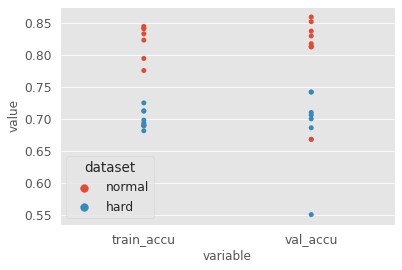

In [117]:
sns.stripplot(data=df, x='variable', y='value', hue='dataset', jitter=False)

# Text cleaning on example sentences

In [105]:
drop_idx = []
for _ in range(20):
    idx = devtest_hard.drop(drop_idx).line1.apply(len).idxmin()
    drop_idx.append(idx)
line1 = devtest_hard.line1[idx]
print(line1)
print(clean_text(line1))
print(clean_text(line1, remove_punkt=True))
print(clean_text(line1, remove_stopwords=True))
print(clean_text(line1, stem=True), end='\n\n')
line2 = devtest_hard.line2[idx]
print(line2)
print(clean_text(line2))
print(clean_text(line2, remove_punkt=True))
print(clean_text(line2, remove_stopwords=True))
print(clean_text(line2, stem=True))

Steam can also be used , and does not need to be pumped .
['steam', 'can', 'also', 'be', 'used', ',', 'and', 'does', 'not', 'need', 'to', 'be', 'pumped', '.']
['steam', 'can', 'also', 'be', 'used', 'and', 'does', 'not', 'need', 'to', 'be', 'pumped']
['steam', 'also', 'used', ',', 'need', 'pumped', '.']
['steam', 'can', 'also', 'be', 'use', ',', 'and', 'doe', 'not', 'need', 'to', 'be', 'pump', '.']

Steam can also be pumped and need not be used .
['steam', 'can', 'also', 'be', 'pumped', 'and', 'need', 'not', 'be', 'used', '.']
['steam', 'can', 'also', 'be', 'pumped', 'and', 'need', 'not', 'be', 'used']
['steam', 'also', 'pumped', 'need', 'used', '.']
['steam', 'can', 'also', 'be', 'pump', 'and', 'need', 'not', 'be', 'use', '.']


In [108]:
devtest_hard.is_paraphrase[idx]

0

In [107]:
print(editdistance.eval(clean_text(line1), clean_text(line2)))
print(editdistance.eval(
    clean_text(line1, remove_punkt=True),
    clean_text(line2, remove_punkt=True)
))
print(editdistance.eval(
    clean_text(line1, remove_stopwords=True),
    clean_text(line2, remove_stopwords=True)
))
print(editdistance.eval(
    clean_text(line1, stem=True),
    clean_text(line2, stem=True)
))

6
5
3
6


# Feature visualization

Violin plots: `tokenized, tokenized-rmv-punkt`, `hue=difficulty`

In [122]:
# scatter w/ color label
kws = None
# kws = {'remove_punkt': True, 'remove_stopwords': True}
X = construct_features(dev.line1.apply(clean_text, kws), 
                       dev.line2.apply(clean_text, kws))
dev_df = pd.DataFrame({
    'unigrams': X[:, 0],
    'edit_dist': X[:, 1],
    'labels': dev.is_paraphrase
})

<AxesSubplot:xlabel='unigrams', ylabel='edit_dist'>

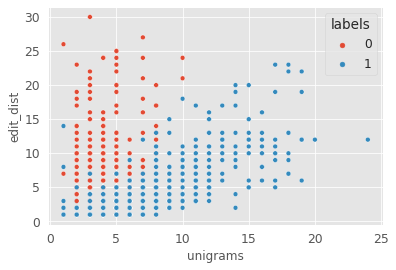

In [124]:
sns.scatterplot(data=dev_df, x='unigrams', y='edit_dist', hue='labels')

<AxesSubplot:xlabel='unigrams', ylabel='edit_dist'>

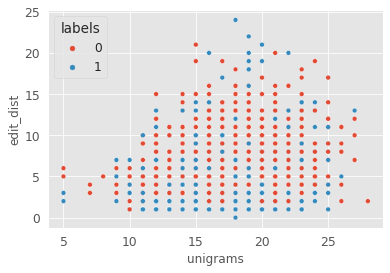

In [125]:
kws = None
# kws = {'remove_punkt': True, 'remove_stopwords': True}
X = construct_features(dev_hard.line1.apply(clean_text, kws), 
                       dev_hard.line2.apply(clean_text, kws))
dev_hard_df = pd.DataFrame({
    'unigrams': X[:, 0],
    'edit_dist': X[:, 1],
    'labels': dev_hard.is_paraphrase
})
sns.scatterplot(data=dev_hard_df, x='unigrams', y='edit_dist', hue='labels')

In [128]:
display(dev_df.corr())
display(dev_hard_df.corr())

,unigrams,edit_dist,labels
unigrams,1.0000,0.2877,0.4417
edit_dist,0.2877,1.0000,-0.2765
labels,0.4417,-0.2765,1.0000


,unigrams,edit_dist,labels
unigrams,1.0000,0.2335,-0.0429
edit_dist,0.2335,1.0000,-0.2896
labels,-0.0429,-0.2896,1.0000


# Error analysis

<AxesSubplot:>

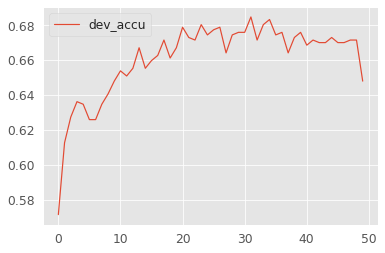

In [119]:
rnn_df = pd.read_csv('output/rnn_training.csv')
rnn_df.dev_accu.plot(legend=True)